In [42]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

pd.options.display.max_columns = 999

# Maryland

## VEST Documentation

Election results from the Maryland State Board of Elections (https://elections.maryland.gov/elections/2020/election_data/index.html)  

Precinct shapefiles primarily sourced from the respective county governments.  

Caroline, Dorchester, Kent, Talbot, Somerset, and Worcester instead sourced from the Maryland Department of Planning.

G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Green Party)  
G20PREBSEG - Jerome M. Segal (Bread and Roses Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [43]:
vest_md_20 = gp.read_file("./raw-from-source/VEST/md_2020/md_2020.shp")

In [44]:
data_columns = [col for col in vest_md_20.columns if "G20" in col]

## Load, Clean and Process MD Day Of File

Note: Maryland splits election results between votes on the day of for the precincts and early, provisional, and absentee, which have to be downloaded separately.

In [45]:
#Load file
source_elections = pd.read_csv("./raw-from-source/Election_Results/Election_Day/All_By_Precinct_2020_General.csv")

#Clean the office name
source_elections["Office Name"] = source_elections["Office Name"].str.strip()

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [46]:
#Define a function to swap position in a list
def swapPositions(list, pos1, pos2):
    list[pos1], list[pos2] = list[pos2], list[pos1]
    return list
 
# Swap the order of two counties (St. Mary's and Somerset - thrown off because of the "St.")
juris_list = swapPositions(sorted(vest_md_20["JURSCODE"].unique()), 18, 19)

In [47]:
source_elections["Office Name"].unique()

array(['President - Vice Pres', 'Representative in Congress',
       'Judge Special Appeals At Large', 'Judge Special Appeals',
       'Board of Education', 'Council - City of Cumberland',
       'Judge of the Circuit Court', 'Judge Court of Appeals', 'Mayor',
       'President City Council', 'Comptroller', 'Member City Council',
       'County Executive', 'County Council',
       'Board of Education At Large', 'Mayor of Hagerstown',
       'Hagerstown Council'], dtype=object)

In [48]:
#Create a dictionary mapping from county number to the JURSCODE (shortened county name)
num_juris_dict = dict(zip(range(1,25),juris_list))

#Apply the dictionary
source_elections["JURSCODE"] = source_elections["County"].map(num_juris_dict)

#Filter down to the relevant offices
source_elections = source_elections[source_elections["Office Name"].isin(['President - Vice Pres'])]

#Make a column that captures the county, election district, and precinct
source_elections["pivot_col"] = source_elections["JURSCODE"].astype(str)+"-"+source_elections["Election District"].astype(str).str.zfill(3)+"-"+source_elections["Election Precinct"].astype(str).str.zfill(3)



In [49]:
fips_dict = {'HOWA':"027", 'MONT':"031", 'PRIN':"033", 'STMA':"037",
             'QUEE':"035", 'WASH':"043", 'WICO':"045", 'CHAR':"017",
             'KENT':"029", 'CARO':"011", 'TALB':"041", 'DORC':"019", 
             'WORC':"047", 'SOME':"039", 'ALLE':"001", 'ANNE':"003",
             'BACI':"510", 'BACO':"005", 'CALV':"009", 'CARR':"013",
             'CECI':"015", 'FRED':"021", 'GARR':"023", 'HARF':"025"}

In [50]:
source_elections["Candidate Name"].unique()

array(['Donald J. Trump', 'Joe Biden', 'Jo Jorgensen',
       'Howie Gresham Hawkins', 'Jerome M. Segal', 'Sharon Wallace',
       'Dennis Andrew Ball', 'Barbara Bellar', 'President Boddie',
       'Mary Ruth Caro Simmons', 'Brian Carroll', 'Todd Cella',
       'Mark Charles', 'Phil Collins', 'Roque Rocky De La Fuente',
       'Ryan Ehrenreich', 'Randall Foltyniewkz', 'Tom Hoefling',
       'Shawn Howard', 'Johnson Lee', 'Susan B. Lochocki', 'Brock Pierce',
       'Deborah Rouse', 'Peter W. Sherrill', 'Jade Simmons',
       'Kasey Wells', 'Kanye West', 'Gloria La Riva ', 'Albert Raley',
       'Benjamin Schwalb', 'Edward Shlikas', 'Other Write-Ins'],
      dtype=object)

In [10]:
vest_md_20

,NAME,NUMBER,JURSCODE,VOTESPRE,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREBSEG,G20PREOWRI,geometry
0,HOWARD PRECINCT 06-001,06-001,HOWA,006-001,1005,402,30,6,5,11,"POLYGON Z ((1360475.813 539373.556 0.000, 1360..."
1,HOWARD PRECINCT 05-023,05-023,HOWA,005-023,1116,190,14,4,2,9,"POLYGON Z ((1343191.760 567973.996 0.000, 1343..."
2,HOWARD PRECINCT 05-018,05-018,HOWA,005-018,896,159,8,2,1,9,"POLYGON Z ((1344525.177 561849.349 0.000, 1344..."
3,HOWARD PRECINCT 05-017,05-017,HOWA,005-017,1085,290,14,6,3,13,"POLYGON Z ((1344438.747 561396.875 0.000, 1344..."
4,HOWARD PRECINCT 05-020,05-020,HOWA,005-020,1188,663,22,6,1,21,"POLYGON Z ((1336832.452 540093.639 0.000, 1336..."
...,...,...,...,...,...,...,...,...,...,...,...
2038,BALTIMORE CITY PRECINCT 20-012,20-012,BACI,020-012,0,0,0,0,0,0,"POLYGON Z ((1407857.819 586561.714 0.000, 1407..."
2039,BALTIMORE CITY PRECINCT 21-005,21-005,BACI,021-005,0,0,0,0,0,0,"POLYGON Z ((1419677.416 590070.664 0.000, 1419..."
2040,BALTIMORE CITY PRECINCT 12-013,12-013,BACI,012-013,0,0,0,0,0,0,"POLYGON Z ((1419816.007 603499.927 0.000, 1419..."
2041,PRINCE GEORGE'S PRECINCT 21-093,21-093,PRIN,021-093,0,0,0,0,0,0,"POLYGON Z ((1335913.500 485150.969 0.000, 1335..."


In [ ]:
source_elections["Candidate Name"].unique()

In [11]:
name_change_dict = {'Donald J. Trump':'G20PRERTRU', 
 'Joe Biden':'G20PREDBID', 
 'Jo Jorgensen':'G20PRELJOR',
'Howie Gresham Hawkins':'G20PREGHAW',
 'Jerome M. Segal':'G20PREBSEG'}

source_elections["Candidate Name"] = source_elections["Candidate Name"].map(name_change_dict).fillna('G20PREOWRI')

In [12]:
source_elections["Candidate Name"].unique()

array(['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW',
       'G20PREBSEG', 'G20PREOWRI'], dtype=object)

In [13]:
#Pivot the data
pivoted_results = pd.pivot_table(source_elections,index=["pivot_col"],columns=["Candidate Name"],values=['Total Votes'],aggfunc=sum)

#Clean up the columns and indices
pivoted_results = pivoted_results.fillna(0)
pivoted_results.columns = pivoted_results.columns.droplevel(0)
pivoted_results.reset_index(drop=False,inplace=True)

In [14]:
print(pivoted_results)

Candidate Name     pivot_col  G20PREBSEG  G20PREDBID  G20PREGHAW  G20PRELJOR  \
0               ALLE-001-000         0.0        76.0         2.0         6.0   
1               ALLE-002-000         0.0        81.0         0.0         5.0   
2               ALLE-003-000         0.0        80.0         2.0         2.0   
3               ALLE-004-002         2.0       133.0         4.0         5.0   
4               ALLE-004-003         1.0       238.0         8.0         6.0   
...                      ...         ...         ...         ...         ...   
2030            WORC-005-002         3.0      1071.0        10.0        31.0   
2031            WORC-006-001         1.0      1066.0         7.0        15.0   
2032            WORC-006-002         0.0       275.0         2.0        21.0   
2033            WORC-006-003         1.0       478.0         6.0        11.0   
2034            WORC-007-001         0.0      1718.0         9.0        55.0   

Candidate Name  G20PREOWRI  G20PRERTRU 

In [15]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [16]:
statewide_totals_check(vest_md_20,pivoted_results,data_columns)

***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 1985023
G20PRERTRU has a difference of 2.0 votes
	VEST: 976414 votes
	SOURCES: 976412.0 votes
G20PRELJOR is equal 	VEST / RDH: 33488
G20PREGHAW is equal 	VEST / RDH: 15799
G20PREBSEG is equal 	VEST / RDH: 5884
G20PREOWRI has a difference of 380.0 votes
	VEST: 20423 votes
	SOURCES: 20043.0 votes


In [17]:
pivoted_results["JURSCODE"] = pivoted_results["pivot_col"].apply(lambda x: x.split("-")[0])

In [18]:
pivoted_results["JURSCODE"].unique()

array(['ALLE', 'ANNE', 'BACI', 'BACO', 'CALV', 'CARO', 'CARR', 'CECI',
       'CHAR', 'DORC', 'FRED', 'GARR', 'HARF', 'HOWA', 'KENT', 'MONT',
       'PRIN', 'QUEE', 'SOME', 'STMA', 'TALB', 'WASH', 'WICO', 'WORC'],
      dtype=object)

In [19]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [20]:
county_totals_check(vest_md_20,pivoted_results,data_columns,"JURSCODE",full_print=False)

***Countywide Totals Check***

G20PREDBID is equal across all counties
G20PRERTRU contains differences in these counties:
	GARR has a difference of 2.0 votes
		VEST: 12002 votes
		SOURCES: 12000.0 votes
G20PRELJOR is equal across all counties
G20PREGHAW is equal across all counties
G20PREBSEG is equal across all counties
G20PREOWRI contains differences in these counties:
	ALLE has a difference of 19.0 votes
		VEST: 130 votes
		SOURCES: 111.0 votes
	BACI has a difference of 119.0 votes
		VEST: 1272 votes
		SOURCES: 1153.0 votes
	CALV has a difference of 1.0 votes
		VEST: 281 votes
		SOURCES: 280.0 votes
	CARO has a difference of 7.0 votes
		VEST: 65 votes
		SOURCES: 58.0 votes
	CECI has a difference of 19.0 votes
		VEST: 189 votes
		SOURCES: 170.0 votes
	CHAR has a difference of 50.0 votes
		VEST: 435 votes
		SOURCES: 385.0 votes
	DORC has a difference of 1.0 votes
		VEST: 43 votes
		SOURCES: 42.0 votes
	FRED has a difference of 93.0 votes
		VEST: 1047 votes
		SOURCES: 954.0 votes
	GARR

## Precinct-by-Precinct

In [21]:
vest_md_20

,NAME,NUMBER,JURSCODE,VOTESPRE,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREBSEG,G20PREOWRI,geometry
0,HOWARD PRECINCT 06-001,06-001,HOWA,006-001,1005,402,30,6,5,11,"POLYGON Z ((1360475.813 539373.556 0.000, 1360..."
1,HOWARD PRECINCT 05-023,05-023,HOWA,005-023,1116,190,14,4,2,9,"POLYGON Z ((1343191.760 567973.996 0.000, 1343..."
2,HOWARD PRECINCT 05-018,05-018,HOWA,005-018,896,159,8,2,1,9,"POLYGON Z ((1344525.177 561849.349 0.000, 1344..."
3,HOWARD PRECINCT 05-017,05-017,HOWA,005-017,1085,290,14,6,3,13,"POLYGON Z ((1344438.747 561396.875 0.000, 1344..."
4,HOWARD PRECINCT 05-020,05-020,HOWA,005-020,1188,663,22,6,1,21,"POLYGON Z ((1336832.452 540093.639 0.000, 1336..."
...,...,...,...,...,...,...,...,...,...,...,...
2038,BALTIMORE CITY PRECINCT 20-012,20-012,BACI,020-012,0,0,0,0,0,0,"POLYGON Z ((1407857.819 586561.714 0.000, 1407..."
2039,BALTIMORE CITY PRECINCT 21-005,21-005,BACI,021-005,0,0,0,0,0,0,"POLYGON Z ((1419677.416 590070.664 0.000, 1419..."
2040,BALTIMORE CITY PRECINCT 12-013,12-013,BACI,012-013,0,0,0,0,0,0,"POLYGON Z ((1419816.007 603499.927 0.000, 1419..."
2041,PRINCE GEORGE'S PRECINCT 21-093,21-093,PRIN,021-093,0,0,0,0,0,0,"POLYGON Z ((1335913.500 485150.969 0.000, 1335..."


In [22]:
pivoted_results["unique_ID"] = pivoted_results["pivot_col"]

In [23]:
vest_md_20["unique_ID"]=vest_md_20["JURSCODE"]+"-"+vest_md_20["VOTESPRE"]

In [24]:
pivoted_results["unique_ID"].value_counts(dropna=False)

MONT-013-067    1
PRIN-014-015    1
PRIN-013-017    1
BACO-010-005    1
QUEE-004-006    1
               ..
DORC-014-002    1
BACO-002-021    1
PRIN-013-023    1
HOWA-005-011    1
BACO-012-002    1
Name: unique_ID, Length: 2035, dtype: int64

In [25]:
vest_md_20["unique_ID"].value_counts(dropna=False)

BACO-000-000    2
HARF-001-015    1
ANNE-001-006    1
MONT-005-023    1
MONT-013-034    1
               ..
BACI-027-056    1
BACO-011-013    1
CARR-014-003    1
HOWA-006-030    1
BACO-012-002    1
Name: unique_ID, Length: 2042, dtype: int64

<AxesSubplot:>

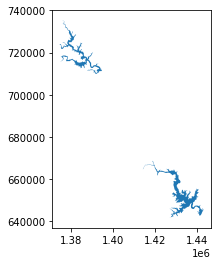

In [26]:
vest_md_20[vest_md_20["unique_ID"]=="BACO-000-000"].plot()

In [27]:
vest_md_20 = vest_md_20.dissolve(by='unique_ID')

In [28]:
vest_md_20.reset_index(drop=False,inplace=True)

In [30]:
merge_attempt_one = pd.merge(pivoted_results,vest_md_20,on="unique_ID",how="outer",validate="1:1",indicator=True)

In [31]:
merge_attempt_one["_merge"].value_counts()

both          2023
right_only      19
left_only       12
Name: _merge, dtype: int64

In [32]:
merge_attempt_one[merge_attempt_one["_merge"]=="left_only"].to_csv("./results_only.csv")

In [33]:
merge_attempt_one[merge_attempt_one["_merge"]=="right_only"].to_csv("./vest_only.csv")

In [34]:
ID_changes = {'WASH-001-000':'WASH-001-001',
'WASH-002-000':'WASH-002-001',
'WASH-004-000':'WASH-004-001',
'WASH-005-000':'WASH-005-001',
'WASH-008-000':'WASH-008-001',
'WASH-009-000':'WASH-009-001',
'WASH-012-000':'WASH-012-001',
'WASH-015-000':'WASH-015-001',
'WASH-016-000':'WASH-016-001',
'WASH-019-000':'WASH-019-001',
'WASH-020-000':'WASH-020-001',
'WASH-023-000':'WASH-023-001'}

In [36]:
pivoted_results["unique_ID"] = pivoted_results["unique_ID"].map(ID_changes).fillna(pivoted_results["unique_ID"])

In [37]:
merge_attempt_two = pd.merge(pivoted_results,vest_md_20,on="unique_ID",how="outer",validate="1:1",indicator=True)

In [38]:
merge_attempt_two["_merge"].value_counts()

both          2035
right_only       7
left_only        0
Name: _merge, dtype: int64

In [39]:
merge_attempt_two[merge_attempt_two["_merge"]=="right_only"]

,pivot_col,G20PREBSEG_x,G20PREDBID_x,G20PREGHAW_x,G20PRELJOR_x,G20PREOWRI_x,G20PRERTRU_x,JURSCODE_x,unique_ID,geometry,NAME,NUMBER,JURSCODE_y,VOTESPRE,G20PREDBID_y,G20PRERTRU_y,G20PRELJOR_y,G20PREGHAW_y,G20PREBSEG_y,G20PREOWRI_y,_merge
2035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALLE-006-099,"POLYGON Z ((809096.065 732556.367 0.000, 80974...",ALLEGANY PRECINCT 06-099,06-099,ALLE,006-099,0,0,0,0,0,0,right_only
2036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANNE-001-099,"POLYGON Z ((1377161.243 523338.071 0.000, 1377...",ANNE ARUNDEL PRECINCT 01-099,01-099,ANNE,001-099,0,0,0,0,0,0,right_only
2037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANNE-004-099,"POLYGON Z ((1386034.757 505720.367 0.000, 1386...",ANNE ARUNDEL PRECINCT 04-099,04-099,ANNE,004-099,0,0,0,0,0,0,right_only
2038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BACO-000-000,MULTIPOLYGON Z (((1419056.952 668512.868 0.000...,BALTIMORE PRECINCT 00-000,00-000,BACO,000-000,0,0,0,0,0,0,right_only
2039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BACO-011-025,"POLYGON Z ((1474888.659 623934.578 0.000, 1474...",BALTIMORE PRECINCT 11-025,11-025,BACO,011-025,0,0,0,0,0,0,right_only
2040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DORC-001-002,MULTIPOLYGON Z (((1650763.383 314826.186 0.000...,DORCHESTER PRECINCT 01-002,01-002,DORC,001-002,0,0,0,0,0,0,right_only
2041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SOME-000-000,MULTIPOLYGON Z (((1607580.767 118620.831 0.000...,SOMERSET PRECINCT 00-000,00-000,SOME,000-000,0,0,0,0,0,0,right_only


In [40]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [41]:
precinct_votes_check(merge_attempt_two[merge_attempt_two["_merge"]=="both"],data_columns,False,"unique_ID",print_level=0)

G20PREOWRI ............................................................ALLE-004-004 (S) ....8  (V)...10 (D):   -2
G20PREOWRI ............................................................ALLE-006-003 (S) ....3  (V)....5 (D):   -2
G20PREOWRI ............................................................ALLE-006-005 (S) ....4  (V)....6 (D):   -2
G20PREOWRI ............................................................ALLE-006-006 (S) ....5  (V)....6 (D):   -1
G20PREOWRI ............................................................ALLE-007-001 (S) ....2  (V)....3 (D):   -1
G20PREOWRI ............................................................ALLE-010-000 (S) ....2  (V)....3 (D):   -1
G20PREOWRI ............................................................ALLE-012-000 (S) ....5  (V)....7 (D):   -2
G20PREOWRI ............................................................ALLE-018-000 (S) ....1  (V)....3 (D):   -2
G20PREOWRI ............................................................ALLE-023-000 (S) 

G20PREOWRI ............................................................HARF-002-014 (S) ....2  (V)....3 (D):   -1
G20PREOWRI ............................................................HARF-003-002 (S) ...17  (V)...18 (D):   -1
G20PREOWRI ............................................................HARF-003-003 (S) ...22  (V)...24 (D):   -2
G20PREOWRI ............................................................HARF-003-006 (S) ...21  (V)...23 (D):   -2
G20PREOWRI ............................................................HARF-003-009 (S) ...16  (V)...17 (D):   -1
G20PREOWRI ............................................................HARF-003-011 (S) ...10  (V)...11 (D):   -1
G20PREOWRI ............................................................HARF-003-012 (S) ...18  (V)...20 (D):   -2
G20PREOWRI ............................................................HARF-003-014 (S) ...21  (V)...22 (D):   -1
G20PREOWRI ............................................................HARF-003-015 (S) 

## Shapefile

From VEST:

> Precinct shapefiles primarily sourced from the respective county governments.  
Caroline, Dorchester, Kent, Talbot, Somerset, and Worcester instead sourced from the Maryland Department of Planning.

Note: We were unable to find shapefile formatted maps for most of the other counties. All county map data is available upon request

In [51]:
md_shapefile = gp.read_file("/Users/peterhorton/Documents/RDH/pdv/pdv-md/vest-md-20/raw-from-source/Shapefile/precinct2010/Precinct2010_83NadMeters.shp")

In [54]:
md_shapefile_filtered = md_shapefile[md_shapefile["COUNTY"].str[2:5].isin(['011','019','029','039','041','047'])]

In [62]:
md_shapefile_filtered = md_shapefile_filtered.to_crs(vest_md_20.crs)

<AxesSubplot:>

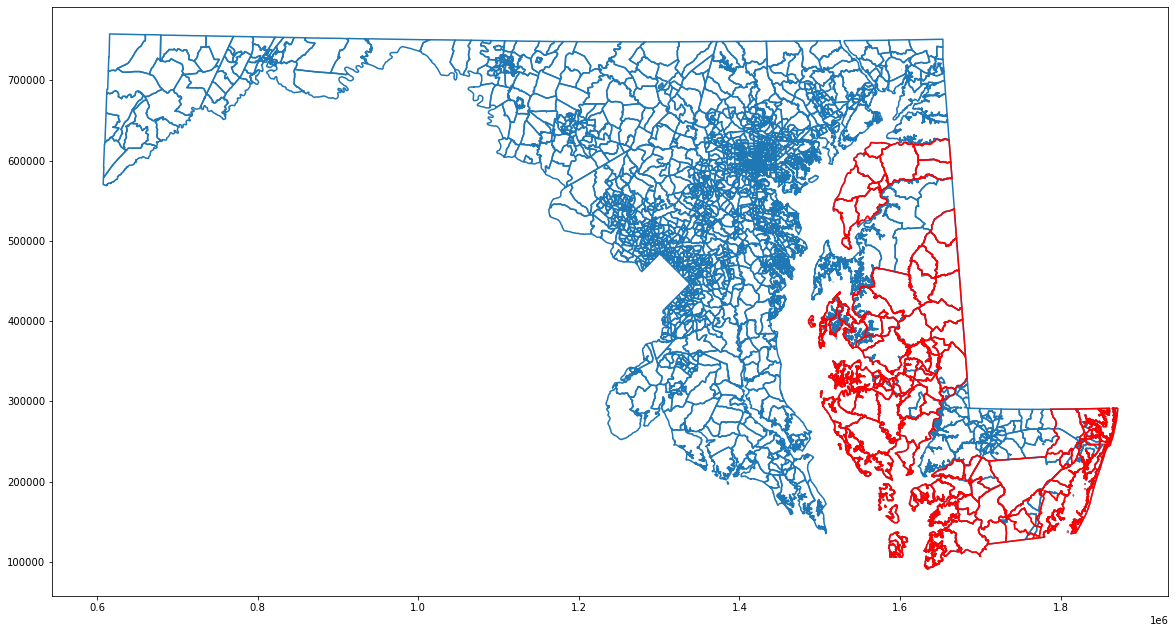

In [66]:
ax = vest_md_20.boundary.plot(figsize=(20,20))
md_shapefile_filtered.boundary.plot(ax=ax,color="red")

Counties to look into:
 
     001 Allegany County
     003 Anne Arundel County
     510 Baltimore City
     005 Baltimore County
     009 Calvert County   
     013 Carroll County
     015 Cecil County
     017 Charles County
     021 Frederick County
     023 Garrett County
     025 Harford County
     027 Howard County
     031 Montgomery County
     033 Prince George's County
     035 Queen Anne's County
     037 St.Mary's County
     043 Washington County
     045 Wicomico County

In [58]:
vest_md_20[vest_md_20["JURSCODE"]=="WICO"]

,NAME,NUMBER,JURSCODE,VOTESPRE,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREBSEG,G20PREOWRI,geometry
693,WICOMICO COUNTY 05-002,05-002,WICO,005-002,231,207,5,6,1,1,MULTIPOLYGON Z (((1721573.876 263922.015 0.000...
694,WICOMICO COUNTY 05-001,05-001,WICO,005-001,1066,289,16,11,14,8,"POLYGON Z ((1719044.537 264448.598 0.000, 1719..."
695,WICOMICO COUNTY 05-004,05-004,WICO,005-004,967,1003,19,9,10,6,"POLYGON Z ((1731785.789 257735.557 0.000, 1731..."
696,WICOMICO COUNTY 05-003,05-003,WICO,005-003,599,548,12,9,3,3,"POLYGON Z ((1725755.045 263845.667 0.000, 1725..."
697,WICOMICO COUNTY 04-001,04-001,WICO,004-001,53,162,7,0,1,0,"POLYGON Z ((1764301.459 265679.328 0.000, 1764..."
698,WICOMICO COUNTY 02-001,02-001,WICO,002-001,526,857,15,6,3,6,"POLYGON Z ((1667749.413 236507.611 0.000, 1667..."
699,WICOMICO COUNTY 04-003,04-003,WICO,004-003,288,854,17,1,4,2,"POLYGON Z ((1778789.544 290257.669 0.000, 1778..."
700,WICOMICO COUNTY 04-002,04-002,WICO,004-002,88,315,5,5,0,0,"POLYGON Z ((1762829.377 278578.421 0.000, 1762..."
701,WICOMICO COUNTY 01-001,01-001,WICO,001-001,223,191,5,4,1,5,"POLYGON Z ((1682958.422 304866.765 0.000, 1683..."
703,WICOMICO COUNTY 01-003,01-003,WICO,001-003,116,481,7,9,1,2,MULTIPOLYGON Z (((1650100.771 264430.401 0.000...
